In [79]:
import numpy as np
import requests
import pandas as pd
import time
from scipy.stats import shapiro, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

* Requete  pour avoir les données Via  l'API

In [35]:
# ---- CONFIGURATION ----
cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']
interval = '1h'
start_date = '2020-02-01'
end_date = '2025-05-01'
limit = 1000  # maximum autorisé par requête

def date_to_ms(date_str):
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    return int(dt.timestamp() * 1000)

def fetch_binance_ohlc(symbol, interval, start_ms, end_ms):
    url = 'https://api.binance.com/api/v3/klines'
    all_data = []
    while start_ms < end_ms:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ms,
            'endTime': end_ms,
            'limit': limit
        }
        response = requests.get(url, params=params)
        data = response.json()
        if not data:
            break
        all_data.extend(data)
        start_ms = data[-1][0] + 1
        time.sleep(0.3)  # évite le blocage par Binance
    return all_data

def process_ohlc(data, symbol):
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'nb_trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['close'] = df['close'].astype(float)
    return df[['datetime', 'close']].rename(columns={'close': f'{symbol}_close'})

# ---- TÉLÉCHARGEMENT ----
start_ms = date_to_ms(start_date)
end_ms = date_to_ms(end_date)

merged_df = None
for symbol in cryptos:
    print(f"Téléchargement de {symbol}...")
    raw_data = fetch_binance_ohlc(symbol, interval, start_ms, end_ms)
    df = process_ohlc(raw_data, symbol)
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='datetime', how='outer')

# ---- EXPORT ----
merged_df.sort_values('datetime', inplace=True)
merged_df.to_csv("crypto_hourly_prices_2020_2025.csv", index=False)
print("Fichier exporté : crypto_hourly_prices_2020_2025.csv")


Téléchargement de BTCUSDT...


KeyboardInterrupt: 

* Importation des données

In [98]:
df_crypto = pd.read_csv(r"C:\Users\kadas\Desktop\Mes_cours\chaffik\Data\crypto_hourly_prices_2020_2025.csv", parse_dates=['datetime'])

* forme de la donnée

In [99]:
df_crypto.shape

(45952, 6)

* Vue sur un echantillon

In [100]:
df_crypto.head(5)

,datetime,BTCUSDT_close,ETHUSDT_close,XRPUSDT_close,LTCUSDT_close,DOGEUSDT_close
0,2020-01-31 23:00:00,9352.89,179.99,0.23946,68.00,0.002378
1,2020-02-01 00:00:00,9383.07,181.09,0.24097,68.46,0.002388
2,2020-02-01 01:00:00,9429.86,183.76,0.24265,72.01,0.002400
3,2020-02-01 02:00:00,9441.88,183.88,0.24251,71.70,0.002410
4,2020-02-01 03:00:00,9432.33,183.51,0.24175,72.74,0.002401


* Pourcentage de valeurs manquantes

In [101]:
df_crypto.isna().mean()*100

datetime          0.0
BTCUSDT_close     0.0
ETHUSDT_close     0.0
XRPUSDT_close     0.0
LTCUSDT_close     0.0
DOGEUSDT_close    0.0
dtype: float64

#### Normalisation des données 

In [102]:
def compute_returns(df_prices):
    """
    À partir d’un DataFrame contenant les colonnes *_close, 
    calcule log-return, centered, standardized, abs-standardized pour chaque crypto.
    """
    df = df_prices.copy()
    crypto_cols = [col for col in df.columns if col.endswith('_close')]

    for col in crypto_cols:
        base = col.replace('_close', '')
        
        # Log-returns : Rendement logarithmique horaire de chaque crypto
        df[f'{base}_log_return'] = np.log(df[col] / df[col].shift(1))
        
        # Moyenne et écart-type (en excluant le premier NaN)
        r = df[f'{base}_log_return']
        mean_r = r.mean()
        std_r = r.std()
        
        # Centrage : Rendements centrés autour de la moyenne
        df[f'{base}_log_return_centered'] = r - mean_r
        
        # Standardisation classique
        df[f'{base}_log_return_std'] = (r - mean_r) / std_r
        
        # Valeur absolue (pour NNAR ou Kalman) : 	Volatilité observable, proxy pour l'entraînement & évaluation

        df[f'{base}_abs_std_return'] = df[f'{base}_log_return_std'].abs()

    return df


* Application de la fonction

In [103]:
df_cryto_prepared = compute_returns(df_crypto)
df_cryto_prepared.head(5)

,datetime,BTCUSDT_close,ETHUSDT_close,XRPUSDT_close,LTCUSDT_close,DOGEUSDT_close,BTCUSDT_log_return,BTCUSDT_log_return_centered,BTCUSDT_log_return_std,BTCUSDT_abs_std_return,...,XRPUSDT_log_return_std,XRPUSDT_abs_std_return,LTCUSDT_log_return,LTCUSDT_log_return_centered,LTCUSDT_log_return_std,LTCUSDT_abs_std_return,DOGEUSDT_log_return,DOGEUSDT_log_return_centered,DOGEUSDT_log_return_std,DOGEUSDT_abs_std_return
0,2020-01-31 23:00:00,9352.89,179.99,0.23946,68.00,0.002378,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01 00:00:00,9383.07,181.09,0.24097,68.46,0.002388,0.003222,0.003171,0.453242,0.453242,...,0.540048,0.540048,0.006742,0.006737,0.647038,0.647038,0.004490,0.004397,0.306001,0.306001
2,2020-02-01 01:00:00,9429.86,183.76,0.24265,72.01,0.002400,0.004974,0.004924,0.703722,0.703722,...,0.597325,0.597325,0.050555,0.050551,4.854713,4.854713,0.004679,0.004585,0.319107,0.319107
3,2020-02-01 02:00:00,9441.88,183.88,0.24251,71.70,0.002410,0.001274,0.001224,0.174875,0.174875,...,-0.054139,0.054139,-0.004314,-0.004319,-0.414754,0.414754,0.004366,0.004273,0.297380,0.297380
4,2020-02-01 03:00:00,9432.33,183.51,0.24175,72.74,0.002401,-0.001012,-0.001062,-0.151807,0.151807,...,-0.275919,0.275919,0.014401,0.014396,1.382557,1.382557,-0.003825,-0.003918,-0.272662,0.272662


In [104]:
df_cryto_prepared.columns

Index(['datetime', 'BTCUSDT_close', 'ETHUSDT_close', 'XRPUSDT_close',
       'LTCUSDT_close', 'DOGEUSDT_close', 'BTCUSDT_log_return',
       'BTCUSDT_log_return_centered', 'BTCUSDT_log_return_std',
       'BTCUSDT_abs_std_return', 'ETHUSDT_log_return',
       'ETHUSDT_log_return_centered', 'ETHUSDT_log_return_std',
       'ETHUSDT_abs_std_return', 'XRPUSDT_log_return',
       'XRPUSDT_log_return_centered', 'XRPUSDT_log_return_std',
       'XRPUSDT_abs_std_return', 'LTCUSDT_log_return',
       'LTCUSDT_log_return_centered', 'LTCUSDT_log_return_std',
       'LTCUSDT_abs_std_return', 'DOGEUSDT_log_return',
       'DOGEUSDT_log_return_centered', 'DOGEUSDT_log_return_std',
       'DOGEUSDT_abs_std_return'],
      dtype='object')

 * Analyse exploratoire des rendements (log_return)

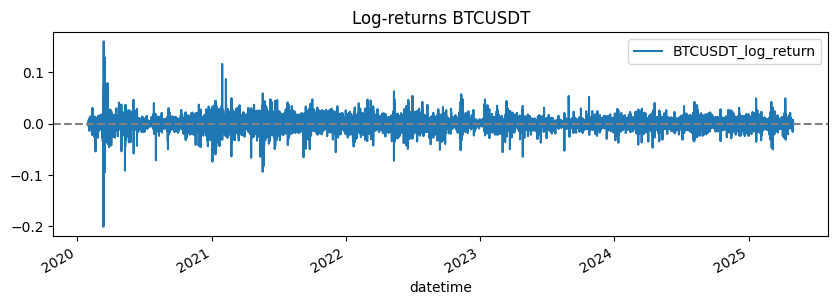

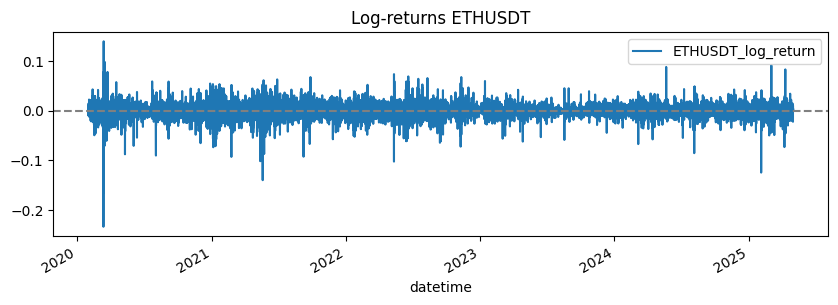

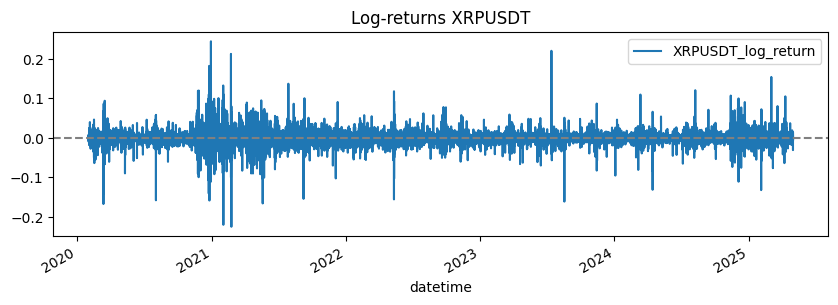

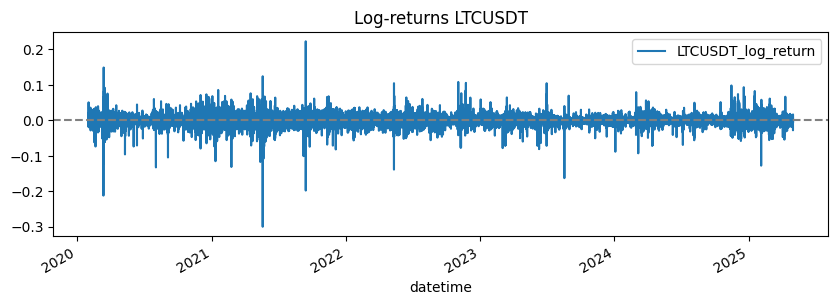

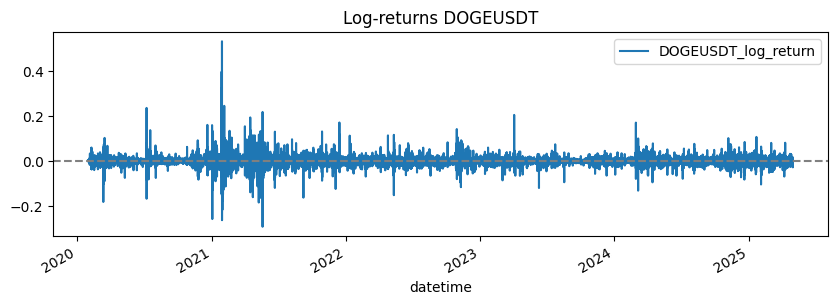

In [105]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    df_cryto_prepared.plot(
        x='datetime',
        y=f'{crypto}_log_return',
        title=f'Log-returns {crypto}',
        figsize=(10, 3)
    )
    plt.axhline(0, linestyle='--', color='grey')
    plt.show()


* Histogrammes + courbe normale

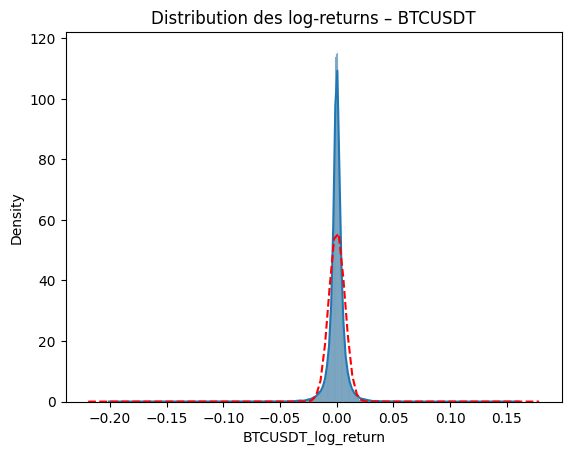

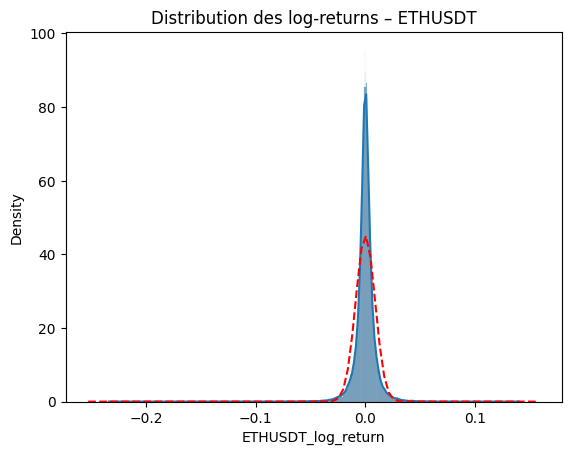

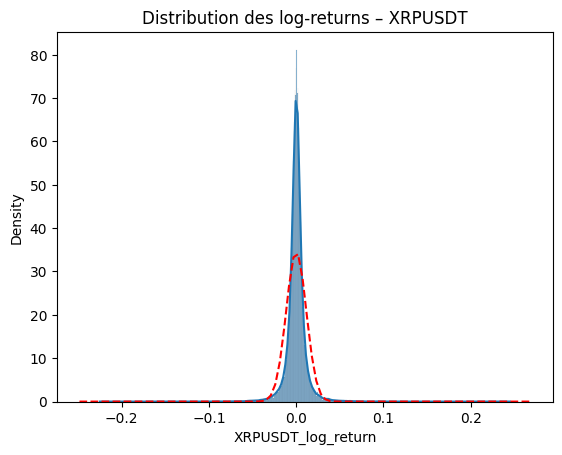

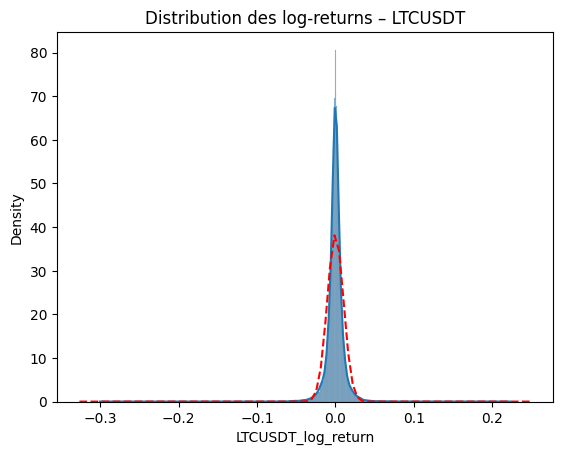

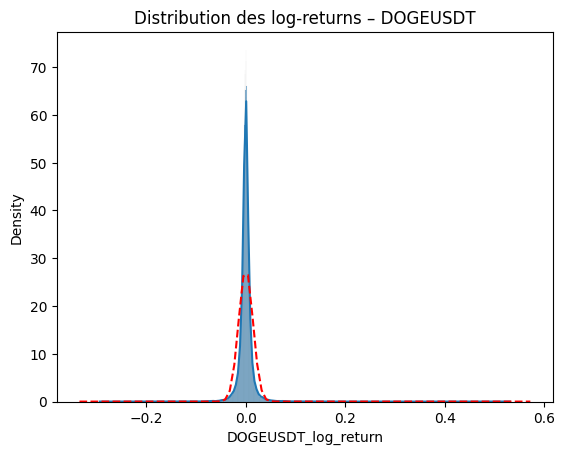

In [106]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_cryto_prepared[f'{crypto}_log_return'].dropna()
    sns.histplot(r, kde=True, stat='density')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, norm.pdf(x, r.mean(), r.std()), 'r--')
    plt.title(f'Distribution des log-returns – {crypto}')
    plt.show()


* Skewness & Kurtosis

In [107]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_cryto_prepared[f'{crypto}_log_return'].dropna()
    print(f"{crypto} | Skew: {skew(r):.2f} | Kurtosis: {kurtosis(r):.2f}")

BTCUSDT | Skew: -0.96 | Kurtosis: 52.05
ETHUSDT | Skew: -0.98 | Kurtosis: 29.63
XRPUSDT | Skew: -0.04 | Kurtosis: 41.21
LTCUSDT | Skew: -1.02 | Kurtosis: 41.60
DOGEUSDT | Skew: 2.26 | Kurtosis: 107.06


# Autocorrélation et stationnarité

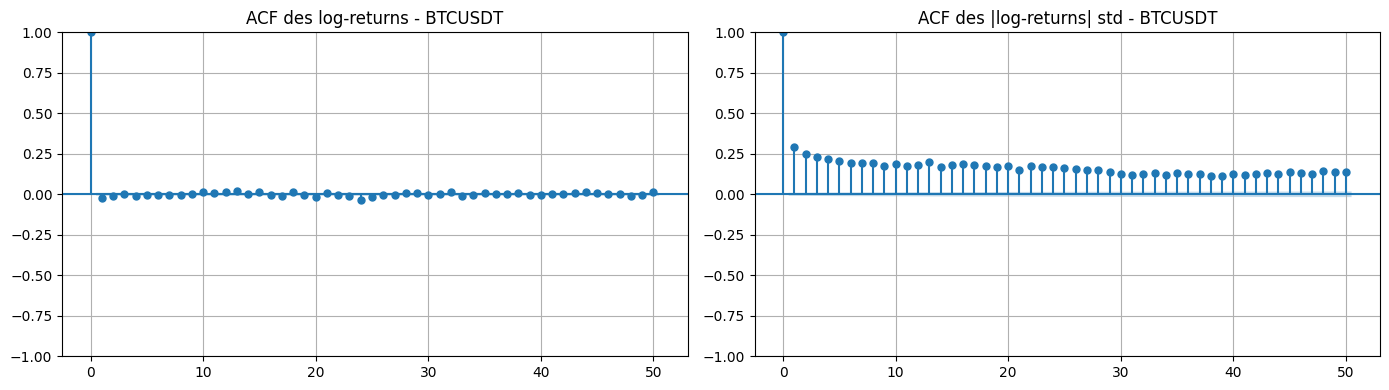

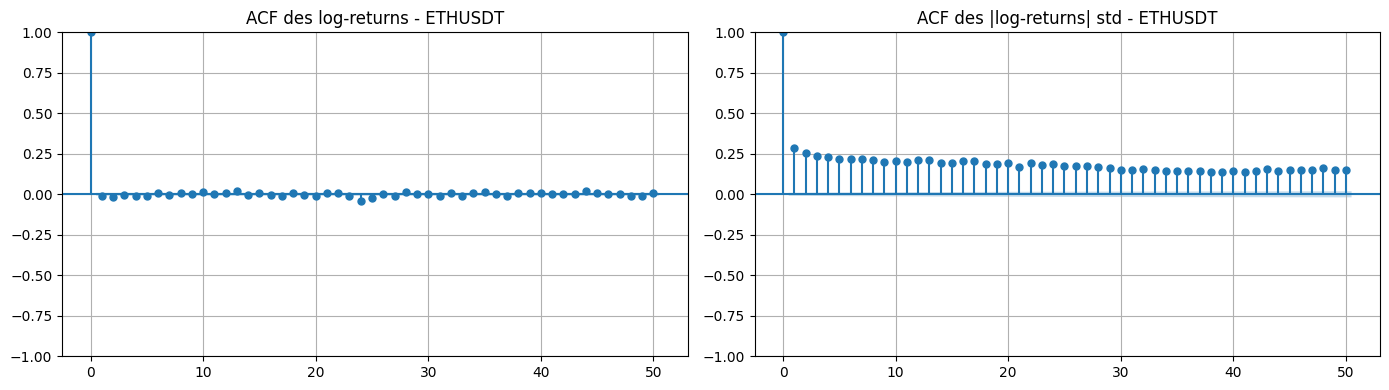

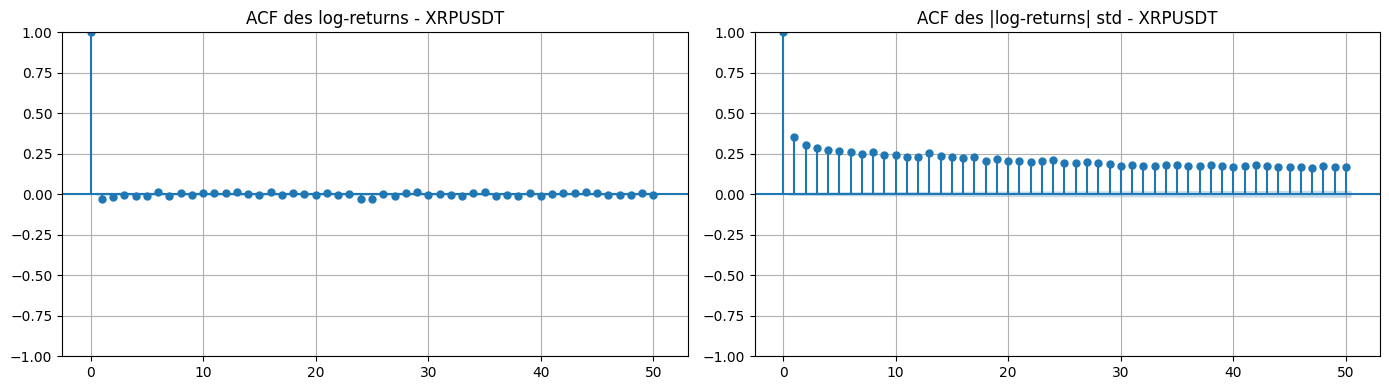

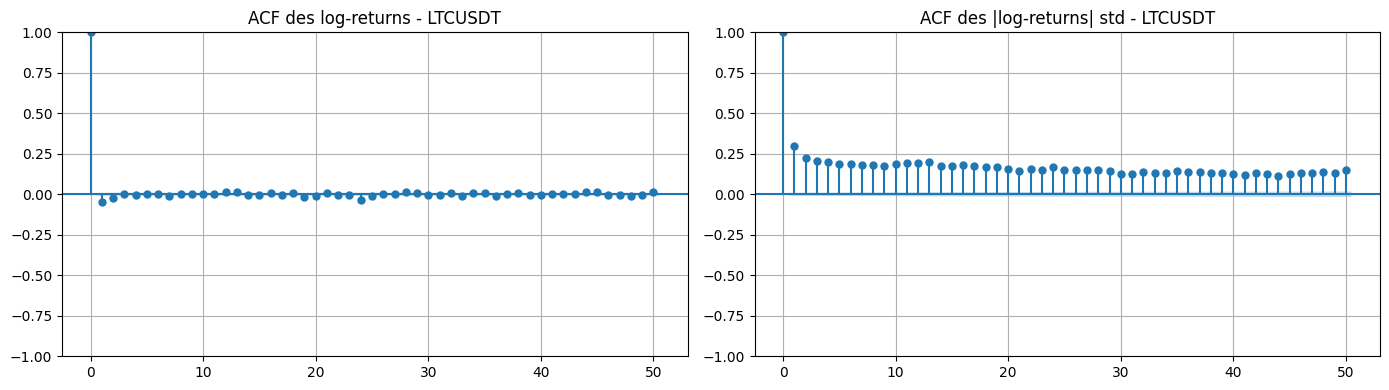

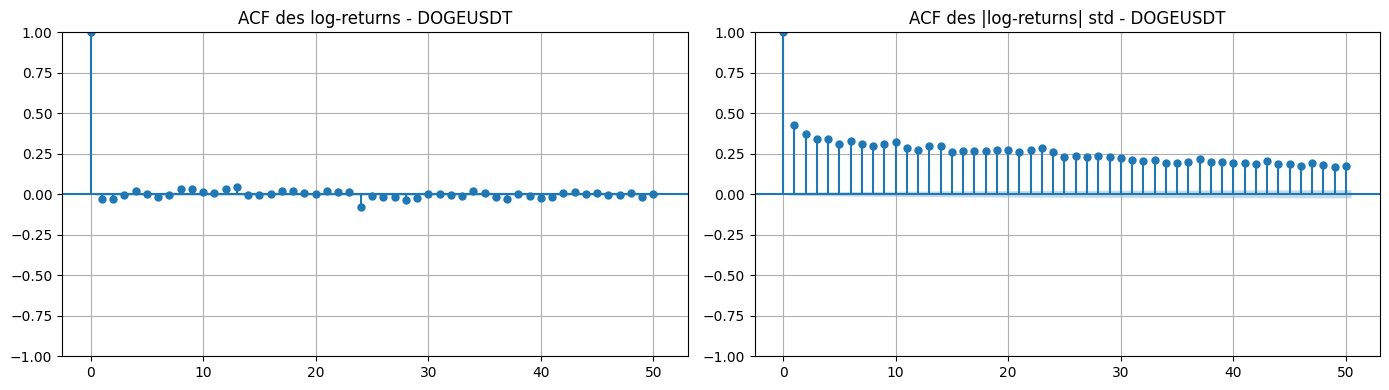

In [108]:
#  ACF / PACF sur log_return et abs_log_return

cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']

for crypto in cryptos:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # ACF log-return
    plot_acf(
        df_cryto_prepared[f'{crypto}_log_return'].dropna(),
        lags=50,
        ax=axes[0]
    )
    axes[0].set_title(f"ACF des log-returns - {crypto}")
    axes[0].grid(True)

    # ACF |log-return| standardisé
    plot_acf(
        df_cryto_prepared[f'{crypto}_abs_std_return'].dropna(),
        lags=50,
        ax=axes[1]
    )
    axes[1].set_title(f"ACF des |log-returns| std - {crypto}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

* Test de stationnarité (Augmented Dickey-Fuller)

In [109]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_cryto_prepared[f'{crypto}_log_return'].dropna()
    adf = adfuller(r)
    print(f"{crypto} – ADF Statistic: {adf[0]:.3f}, p-value: {adf[1]:.3f}")

BTCUSDT – ADF Statistic: -29.785, p-value: 0.000
ETHUSDT – ADF Statistic: -29.616, p-value: 0.000
XRPUSDT – ADF Statistic: -31.329, p-value: 0.000
LTCUSDT – ADF Statistic: -30.356, p-value: 0.000
DOGEUSDT – ADF Statistic: -29.055, p-value: 0.000


Les p-value < 0.05, on rejette H₀ → la série est stationnaire , Tous les log-returns de cryptos sont en général stationnaires, ce qui est une bonne base pour les modèles

* Construction d’une série de volatilité observée

On construis pour chaque crypto une série de volatilité observée lissée, en prenant la moyenne mobile des rendements standardisés absolus sur un pas de 24 heures.

C’est notre "vérité terrain" pour la comparaison des modèles Elle te servira de benchmark ppur  nos métrics

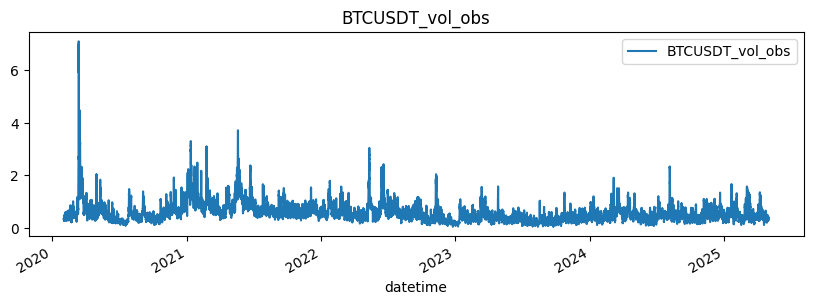

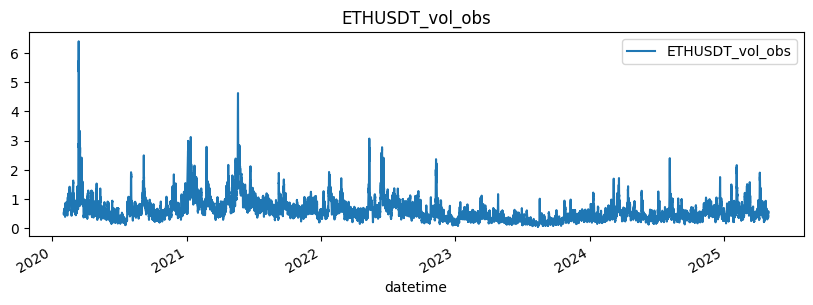

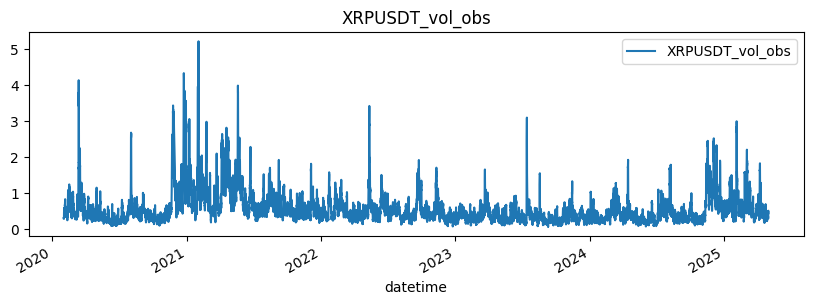

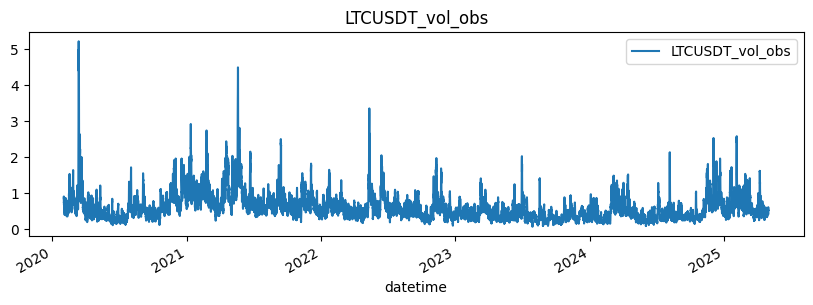

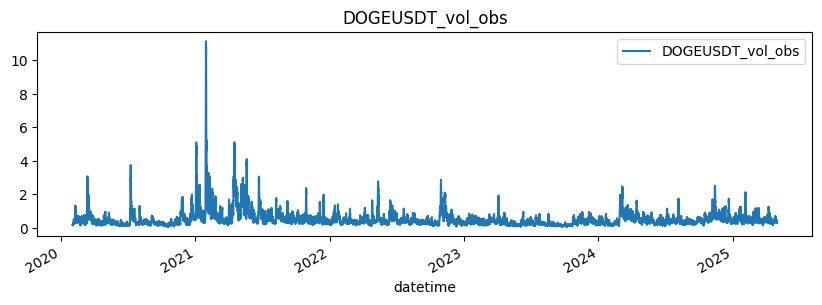

In [110]:
# Détecte toutes les colonnes *_abs_std_return automatiquement
vol_columns = [col for col in df_cryto_prepared.columns if col.endswith('_abs_std_return')]

for col in vol_columns:
    base = col.replace('_abs_std_return', '')  # ex: BTCUSDT ou BTC selon renommage
    df_cryto_prepared[f'{base}_vol_obs'] = df_cryto_prepared[col].rolling(window=24).mean()
for col in df_cryto_prepared.columns:
    if col.endswith('_vol_obs'):
        df_cryto_prepared.plot(x='datetime', y=col, title=col, figsize=(10, 3))
        plt.show()

In [111]:
df_cryto_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45952 entries, 0 to 45951
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datetime                      45952 non-null  datetime64[ns]
 1   BTCUSDT_close                 45952 non-null  float64       
 2   ETHUSDT_close                 45952 non-null  float64       
 3   XRPUSDT_close                 45952 non-null  float64       
 4   LTCUSDT_close                 45952 non-null  float64       
 5   DOGEUSDT_close                45952 non-null  float64       
 6   BTCUSDT_log_return            45951 non-null  float64       
 7   BTCUSDT_log_return_centered   45951 non-null  float64       
 8   BTCUSDT_log_return_std        45951 non-null  float64       
 9   BTCUSDT_abs_std_return        45951 non-null  float64       
 10  ETHUSDT_log_return            45951 non-null  float64       
 11  ETHUSDT_log_return_centered 

# Implémentation des modèles

* State Space Model + Kalman Filter (SS-KF)

In [113]:
# Verification des hypotheses avant de lancer  le modèle

from scipy.stats import shapiro, jarque_bera

# Liste des cryptos à analyser
cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']

# Liste pour stocker les résultats
results = []

for crypto in cryptos:
    print(f" Vérification pour {crypto} ...")
    
    # Récupère les log-returns standardisés déjà présents
    col = f'{crypto}_log_return_std'
    r_std = df_cryto_prepared[col].dropna()  # échantillon limité à 2000
    
    # 1. Test de stationnarité (ADF)
    adf_stat, adf_pval, *_ = adfuller(r_std)
    
    # 2. Tests de normalité
    r_sample = r_std.sample(n=1000, random_state=42) if len(r_std) > 1000 else r_std
    shapiro_stat, shapiro_p = shapiro(r_sample)
    jb_stat, jb_p = jarque_bera(r_std)
    
    # 3. Stocke les résultats
    results.append({
        'Crypto': crypto,
        'ADF_stat': round(adf_stat, 4),
        'ADF_p-value': round(adf_pval, 5),
        'Stationnaire (ADF < 0.05)': adf_pval < 0.05,
        'Shapiro p-value': round(shapiro_p, 5),
        'JB p-value': round(jb_p, 5),
        'Normalité (Shapiro > 0.05)': shapiro_p > 0.05,
        'Normalité (JB > 0.05)': jb_p > 0.05
    })

# Affiche proprement les résultats
df_verif = pd.DataFrame(results)
display(df_verif)


 Vérification pour BTCUSDT ...
 Vérification pour ETHUSDT ...
 Vérification pour XRPUSDT ...
 Vérification pour LTCUSDT ...
 Vérification pour DOGEUSDT ...


,Crypto,ADF_stat,ADF_p-value,Stationnaire (ADF < 0.05),Shapiro p-value,JB p-value,Normalité (Shapiro > 0.05),Normalité (JB > 0.05)
0,BTCUSDT,-29.7852,0.0,True,0.0,0.0,False,False
1,ETHUSDT,-29.6165,0.0,True,0.0,0.0,False,False
2,XRPUSDT,-31.3294,0.0,True,0.0,0.0,False,False
3,LTCUSDT,-30.3559,0.0,True,0.0,0.0,False,False
4,DOGEUSDT,-29.0552,0.0,True,0.0,0.0,False,False


Toutes les séries rejettent l’hypothèse de normalité (tests de Shapiro et Jarque-Bera) → les hypothèses du filtre de Kalman classique sont violées.

*  Implémentons d’abord le filtre de Kalman classique
Pour avoir une baseline.

Traitement de BTCUSDT...


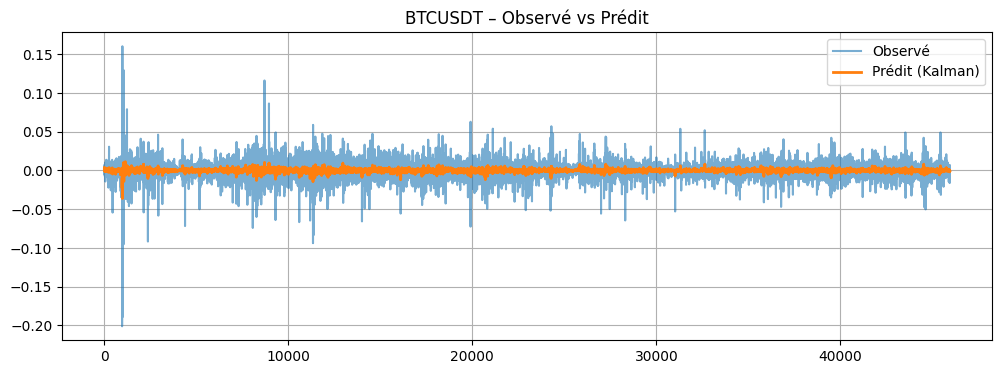

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de ETHUSDT...


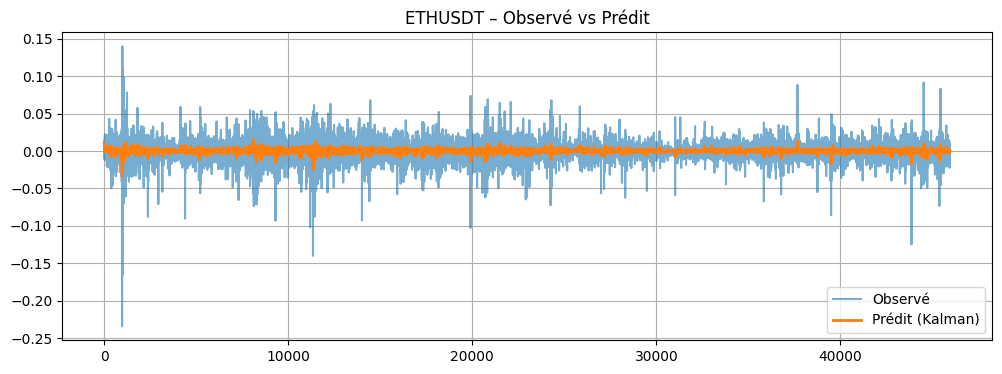

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de XRPUSDT...


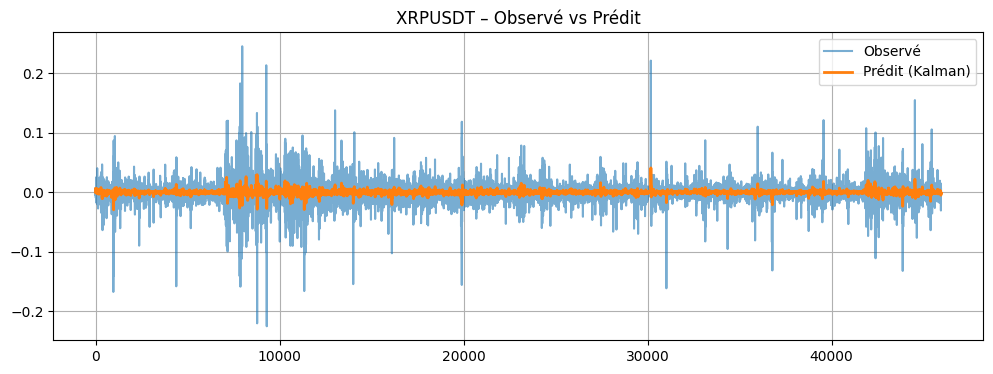

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de LTCUSDT...


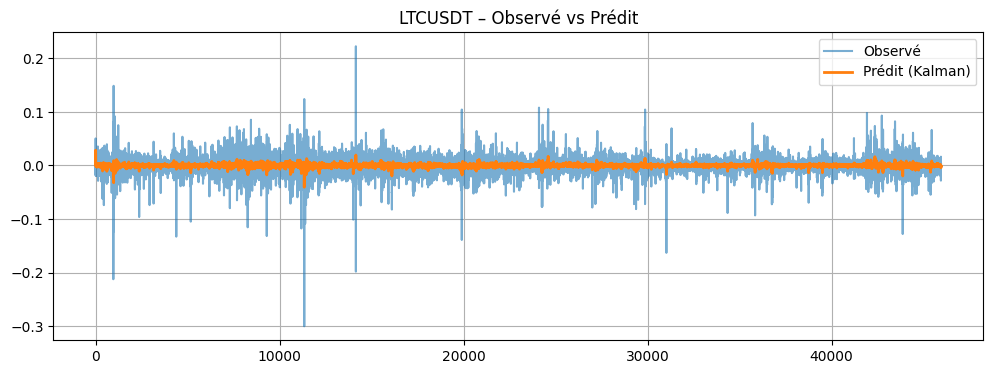

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
Traitement de DOGEUSDT...


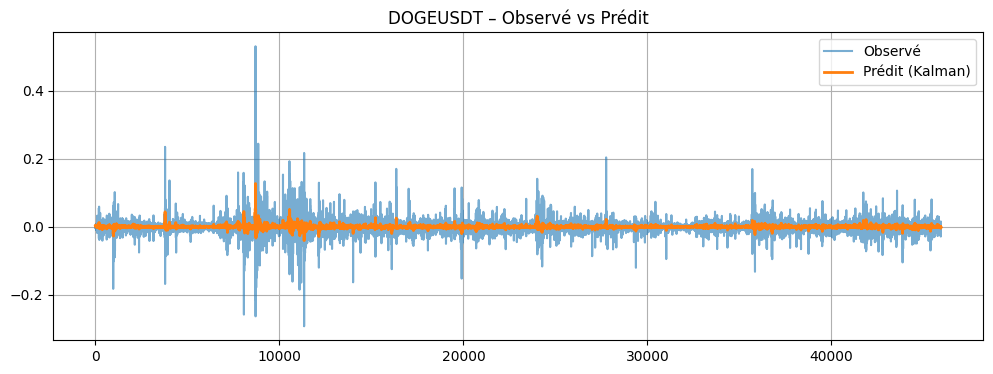

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box (lag=10) p-value : 0.0000 → Résidus indépendants : False
     Crypto       MSE      RMSE       MAE  Log-Likelihood
0   BTCUSDT  0.000042  0.006499  0.003977   166212.349032
1   ETHUSDT  0.000068  0.008218  0.005158   155428.282263
3   LTCUSDT  0.000094  0.009684  0.006107   147887.953909
2   XRPUSDT  0.000115  0.010731  0.006237   143166.639331
4  DOGEUSDT  0.000177  0.013319  0.007156   133239.998068


In [114]:
cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']
results = []


for crypto in cryptos:
    print(f"Traitement de {crypto}...")

    y = df_cryto_prepared[f"{crypto}_log_return"].dropna().values
    n = len(y)

    # Initialisation du filtre
    
    kf = KalmanFilter(
    # Matrice de transition (F) : définit comment l'état évolue entre deux pas de temps
    # F=1.0 signifie qu'on utilise un modèle à marche aléatoire (l'état futur = état actuel)
    # Dans le contexte financier, cela suppose que le rendement attendu est le même que l'actuel
                    transition_matrices=1.0,     # F
    
    # Matrice d'observation (H) : définit comment l'état caché est lié aux observations
    # H=1.0 signifie qu'on observe directement l'état (avec du bruit)
    # Pour les rendements, on suppose qu'on observe directement le "vrai" rendement plus un bruit
                    observation_matrices=1.0,    # H
    
    # Moyenne initiale de l'état : notre meilleure estimation a priori
    # 0.0 suppose que le rendement moyen initial est nul (hypothèse neutre)
                     initial_state_mean=0.0,
    
    # Covariance initiale de l'état : représente notre incertitude sur l'état initial
    # 1.0 est une valeur relativement grande qui indique une faible confiance dans l'état initial
                     initial_state_covariance=1.0,
    
    # Covariance d'observation (R) : représente le bruit dans les mesures
    # R=0.01 suppose que nos observations (rendements) ont un bruit modéré
    # Plus R est grand, moins le filtre fait confiance aux nouvelles observations
    # Plus R est petit, plus le filtre réagit rapidement aux changements dans les données
                     observation_covariance=1e-2,  # R (à ajuster selon la volatilité de chaque crypto)
    
    # Covariance de transition (Q) : représente l'incertitude dans le modèle d'évolution
    # Q=0.0001 est relativement petit, ce qui suppose que notre modèle d'évolution est assez fiable
    # Plus Q est grand, plus le filtre s'adapte rapidement aux changements de régime
    # Plus Q est petit, plus le filtre est stable et résistant au bruit
                     transition_covariance=1e-4    # Q (à ajuster selon la stabilité du processus)
    )

    # Application du filtre
    state_means, state_covs = kf.filter(y)
    y_pred = state_means.flatten()
    residuals = y - y_pred
    
    plt.figure(figsize=(12, 4))
    plt.plot(y, label='Observé', alpha=0.6)
    plt.plot(y_pred, label='Prédit (Kalman)', linewidth=2)
    plt.title(f"{crypto} – Observé vs Prédit")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Normalité
    shapiro_p = shapiro(residuals)[1]
    jb_p = jarque_bera(residuals)[1]
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

    print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
    print(f"Jarque-Bera p-value : {jb_p:.4f} → Normalité :", jb_p > 0.05)
    print(f"Ljung-Box (lag=10) p-value : {lb_test['lb_pvalue'].values[0]:.4f} → Résidus indépendants :", lb_test['lb_pvalue'].values[0] > 0.05)
    

    # Évaluation des performances
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y - y_pred))
        

    residuals = y - y_pred
    log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))

    results.append({
    "Crypto": crypto,
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "Log-Likelihood": log_likelihood
    })

# Résultats consolidés
df_results = pd.DataFrame(results)

# Tri par RMSE (plus pertinent que MSE car interprétable dans les mêmes unités que y)
df_results.sort_values("RMSE", inplace=True)

# Affichage final
print(df_results)

* Conclusion

Le filtre de Kalman classique fonctionne bien en apparence :
Car Faibles MSE

Log-vraisemblance élevée
 
Mais toutes les hypothèses du modèle sont violées :

Non-normalité des résidus → Gaussienne non adaptée

Résidus autocorrélés → La présence d'autocorrélation dans les résidus signifie que le modèle ne capture pas toute la structure temporelle des données

Le filtre de Kalman classique produit des prédictions acceptables (faible MSE), **mais les résidus sont :

non gaussiens,

non indépendants,

et statistiquement non valides.**

Cela signifie que le modèle est structurellement mal spécifié pour ces séries financières


# EKF 
* DOGEUSDT est le pire modèle en Kalman classique (MSE et log-likelihood les plus faibles). 
On  va Passer à un filtre plus robuste

Si EKF améliore les résidus là, il y a forte probabilité qu’il fonctionne aussi sur les autres.

In [115]:
# Récupération des données
y = df_cryto_prepared['DOGEUSDT_log_return'].dropna().values
n = len(y)

# Paramètres du modèle
Q = 1e-4  # variance du bruit de transition
R = 1e-2  # variance du bruit d'observation

# Initialisation
x_pred = np.zeros(n)
P_pred = np.zeros(n)
x_filt = np.zeros(n)
P_filt = np.zeros(n)

x_pred[0] = 0.0
P_pred[0] = 1.0

# Fonction de transition non linéaire
def f(x):
    return np.tanh(x)

# Jacobien de f(x)
def f_jacobian(x):
    return 1.0 - np.tanh(x)**2  # dérivée de tanh

# Observation directe
def h(x):
    return x

# Jacobien de h(x)
def h_jacobian(x):
    return 1.0

# Boucle de filtrage
for t in range(1, n):
    # Prédiction
    x_pred[t] = f(x_filt[t-1])
    F_t = f_jacobian(x_filt[t-1])
    P_pred[t] = F_t * P_filt[t-1] * F_t + Q

    # Innovation
    y_pred = h(x_pred[t])
    H_t = h_jacobian(x_pred[t])
    S_t = H_t * P_pred[t] * H_t + R
    K_t = P_pred[t] * H_t / S_t

    # Mise à jour
    x_filt[t] = x_pred[t] + K_t * (y[t] - y_pred)
    P_filt[t] = (1 - K_t * H_t) * P_pred[t]

# Résidus et métriques
residuals = y - x_filt
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

# Résumé des performances
print(f"MSE (EKF DOGE): {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Log-Likelihood: {log_likelihood:.2f}")
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)


c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


MSE (EKF DOGE): 0.000178
RMSE: 0.013324
MAE: 0.007156
Log-Likelihood: 133223.40
Shapiro-Wilk p-value: 0.0000 → Normalité : False
Jarque-Bera p-value : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


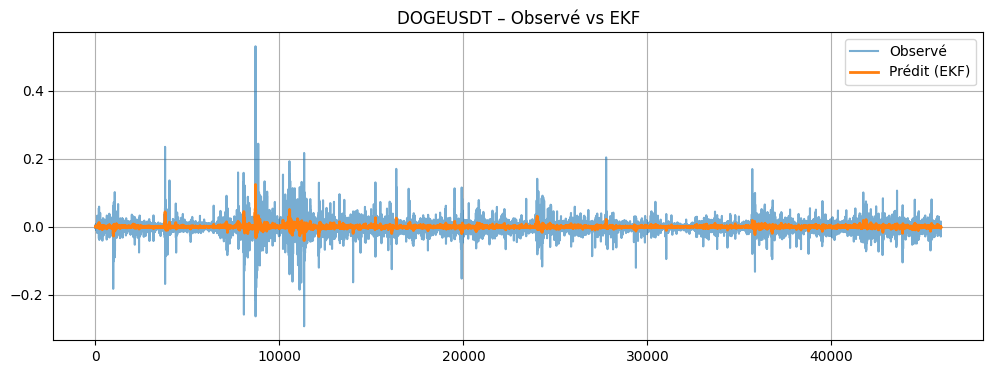

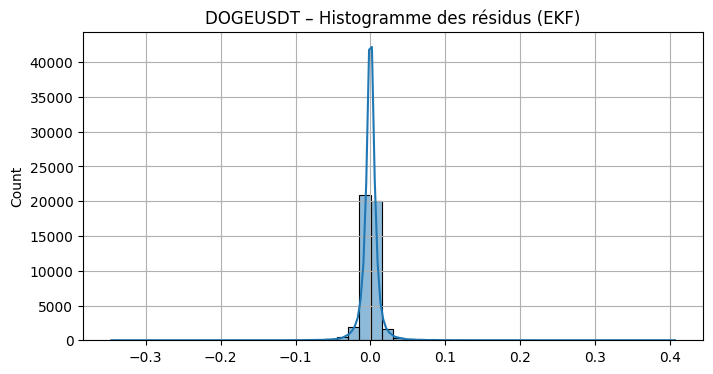

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value  : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


In [116]:
plt.figure(figsize=(12, 4))
plt.plot(y, label='Observé', alpha=0.6)
plt.plot(x_filt, label='Prédit (EKF)', linewidth=2)
plt.title("DOGEUSDT – Observé vs EKF")
plt.legend()
plt.grid()
plt.show()

# Histogramme des résidus
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=50)
plt.title("DOGEUSDT – Histogramme des résidus (EKF)")
plt.grid()
plt.show()

# Tests statistiques
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p = lb_test['lb_pvalue'].values[0]

print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value  : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)


* Conclusions : 

Aucune amélioration significative du MSE ni du log-likelihood.

Les performances sont quasi identiques, ce qui indique que :

Soit la non-linéarité modélisée via tanh
⁡
tanh n’apporte rien ici.

Soit le problème vient moins de la structure dynamique que de la distribution des résidus.

# Passons au filtre robuste 

In [117]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import t

y = df_cryto_prepared['DOGEUSDT_log_return'].dropna().values
n = len(y)

# Fonction de log-vraisemblance avec bruit de Student
def kalman_robust_loglike(params):
    Q, R, df = np.exp(params[0]), np.exp(params[1]), np.exp(params[2]) + 2  # Q, R > 0 ; df > 2
    x_pred = 0.0
    P_pred = 1.0
    loglike = 0.0

    for t_ in range(len(y)):
        # Innovation
        y_pred = x_pred
        S = P_pred + R
        err = y[t_] - y_pred

        # Student-t log-likelihood
        scale = np.sqrt(S)
        loglike += t.logpdf(err / scale, df=df, loc=0, scale=1) - np.log(scale)

        # Kalman gain & update
        K = P_pred / S
        x_pred = x_pred + K * err
        P_pred = (1 - K) * P_pred + Q

    return -loglike  # negative for minimization

# Optimisation
res = minimize(kalman_robust_loglike, x0=np.log([1e-4, 1e-2, 4]), method='L-BFGS-B')
opt_Q, opt_R, opt_df = np.exp(res.x[0]), np.exp(res.x[1]), np.exp(res.x[2]) + 2

print(f" Paramètres optimisés : Q={opt_Q:.6f}, R={opt_R:.6f}, df={opt_df:.2f}")


 Paramètres optimisés : Q=0.000000, R=0.000029, df=2.00


Appliquer le filtre avec les bons paramètres

In [119]:
x_filt = np.zeros(n)
P_filt = np.zeros(n)
x_pred = np.zeros(n)
P_pred = np.zeros(n)

x_pred[0] = 0.0
P_pred[0] = 1.0

for t in range(1, n):
    # Prédiction
    P_pred[t] = P_filt[t-1] + opt_Q
    x_pred[t] = x_filt[t-1]

    # Innovation
    y_pred = x_pred[t]
    S = P_pred[t] + opt_R
    K = P_pred[t] / S
    x_filt[t] = x_pred[t] + K * (y[t] - y_pred)
    P_filt[t] = (1 - K) * P_pred[t]

residuals = y - x_filt
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))
log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))

# Tests statistiques
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]
# Résumé
print(f"MSE : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"Log-Likelihood : {log_likelihood:.2f}")
print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value  : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)


MSE : 0.000206
RMSE : 0.014369
MAE : 0.007581
Log-Likelihood : 129752.43
Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value  : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


Analyse des résidus comme avant

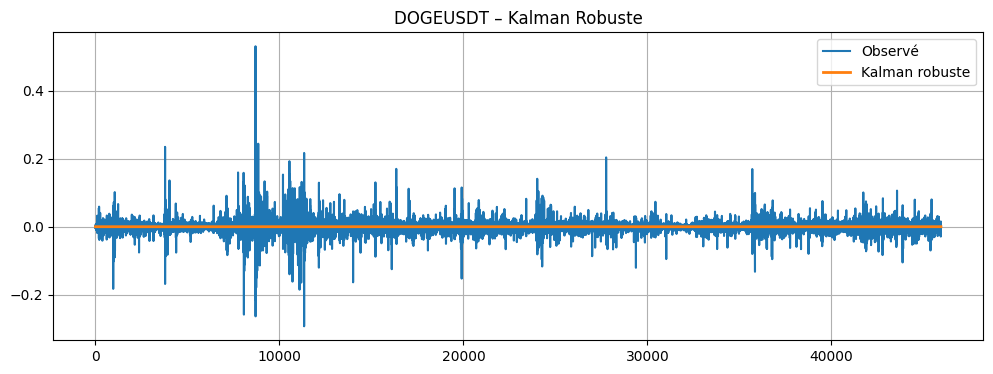

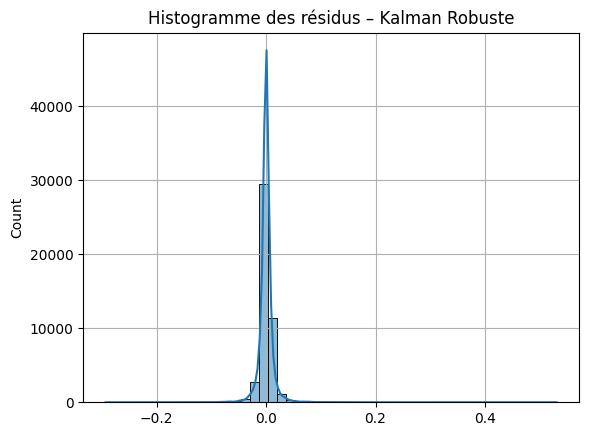

c:\Users\kadas\Desktop\Mes_cours\chaffik\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45951.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk p-value : 0.0000 → Normalité : False
Jarque-Bera p-value  : 0.0000 → Normalité : False
Ljung-Box p-value    : 0.0000 → Résidus indépendants : False


In [120]:
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.figure(figsize=(12, 4))
plt.plot(y, label='Observé')
plt.plot(x_filt, label='Kalman robuste', linewidth=2)
plt.legend()
plt.title("DOGEUSDT – Kalman Robuste")
plt.grid()
plt.show()

# Résidus
sns.histplot(residuals, kde=True, bins=50)
plt.title("Histogramme des résidus – Kalman Robuste")
plt.grid()
plt.show()

# Tests
shapiro_p = shapiro(residuals)[1]
jb_p = jarque_bera(residuals)[1]
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p = lb_test['lb_pvalue'].values[0]

print(f"Shapiro-Wilk p-value : {shapiro_p:.4f} → Normalité :", shapiro_p > 0.05)
print(f"Jarque-Bera p-value  : {jb_p:.4f} → Normalité :", jb_p > 0.05)
print(f"Ljung-Box p-value    : {lb_p:.4f} → Résidus indépendants :", lb_p > 0.05)

Le filtre de Kalman robuste (Student-t) n’a pas corrigé les problèmes fondamentaux :

Non-normalité ,  Dépendance temporelle

Le MSE s’est même dégradé → le modèle a surcorrigé sans gains

# FK robuste pour tous les  crypto

In [121]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import t, norm, shapiro, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']
results = []

for crypto in cryptos:
    print(f"Kalman robuste – {crypto}")
    
    y = df_cryto_prepared[f'{crypto}_log_return'].dropna().values
    n = len(y)

    # Étape 1 : Estimation des paramètres Q, R, df via log-likelihood robustifiée
    def kalman_robust_loglike(params):
        Q, R, df = np.exp(params[0]), np.exp(params[1]), np.exp(params[2]) + 2
        x_pred = 0.0
        P_pred = 1.0
        loglike = 0.0
        for t_ in range(len(y)):
            y_pred = x_pred
            S = P_pred + R
            err = y[t_] - y_pred
            scale = np.sqrt(S)
            loglike += t.logpdf(err / scale, df=df, loc=0, scale=1) - np.log(scale)
            K = P_pred / S
            x_pred = x_pred + K * err
            P_pred = (1 - K) * P_pred + Q
        return -loglike

    # Optimisation
    res = minimize(kalman_robust_loglike, x0=np.log([1e-4, 1e-2, 4]), method='L-BFGS-B')
    opt_Q, opt_R, opt_df = np.exp(res.x[0]), np.exp(res.x[1]), np.exp(res.x[2]) + 2

    # Étape 2 : Filtrage avec paramètres optimisés
    x_filt = np.zeros(n)
    P_filt = np.zeros(n)
    x_pred = np.zeros(n)
    P_pred = np.zeros(n)

    x_pred[0] = 0.0
    P_pred[0] = 1.0

    for t_ in range(1, n):
        P_pred[t_] = P_filt[t_-1] + opt_Q
        x_pred[t_] = x_filt[t_-1]
        y_pred = x_pred[t_]
        S = P_pred[t_] + opt_R
        K = P_pred[t_] / S
        x_filt[t_] = x_pred[t_] + K * (y[t_] - y_pred)
        P_filt[t_] = (1 - K) * P_pred[t_]

    # Résidus
    residuals = y - x_filt
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))

    log_likelihood = np.sum(norm.logpdf(residuals, loc=0, scale=np.std(residuals)))
    shapiro_p = shapiro(residuals)[1]
    jb_p = jarque_bera(residuals)[1]
    lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Résultat
    results.append({
        "Crypto": crypto,
        "Q_opt": opt_Q,
        "R_opt": opt_R,
        "df_opt": opt_df,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Log-Likelihood": log_likelihood,
        "Shapiro p-val": shapiro_p,
        "JB p-val": jb_p,
        "Ljung-Box p-val": lb_p
    })

# Résumé des résultats
df_kalman_robust = pd.DataFrame(results)
display(df_kalman_robust)


Kalman robuste – BTCUSDT
Kalman robuste – ETHUSDT
Kalman robuste – XRPUSDT
Kalman robuste – LTCUSDT
Kalman robuste – DOGEUSDT


,Crypto,Q_opt,R_opt,df_opt,MSE,RMSE,MAE,Log-Likelihood,Shapiro p-val,JB p-val,Ljung-Box p-val
0,BTCUSDT,2.019095e-13,0.000010,2.051407,0.000049,0.006996,0.004196,162823.702828,2.448327e-111,0.0,3.321917e-07
1,ETHUSDT,7.603163e-23,0.000018,2.103415,0.000078,0.008854,0.005452,152004.456961,9.624754e-107,0.0,1.499756e-06
2,XRPUSDT,1.933688e-26,0.000023,2.000030,0.000133,0.011551,0.006607,139786.926022,5.063147e-117,0.0,1.297527e-13
3,LTCUSDT,1.786618e-15,0.000027,2.285740,0.000108,0.010413,0.006452,144552.552167,1.070824e-107,0.0,1.105962e-22
4,DOGEUSDT,7.382351e-16,0.000029,2.000337,0.000206,0.014369,0.007581,129752.425334,1.726181e-125,0.0,1.705905e-40
